In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# fpath='/content/drive/MyDrive/recipes/'

Mounted at /content/drive


In [4]:
!pip install tomotopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.5 MB 23.9 MB/s 


In [5]:
import matplotlib.pyplot as plt
import wordcloud as wc
import pandas as pd
import spacy
import sys
import math
import tomotopy as tp
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
ldamodel = tp.LDAModel
spacy.cli.download("en_core_web_md")
nlp = spacy.load('en_core_web_md')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [6]:
# frec = open(fpath+'RecipeNLG_dataset.csv')
# rec=frec.readlines()
number_of_documents=10000
# receitas=pd.read_csv(fpath+'RecipeNLG_dataset.csv',nrows=number_of_documents)
receitas=pd.read_csv('RecipeNLG_dataset.csv',nrows=number_of_documents)

In [7]:
# for i in range(len(rec['title'])):
#   if 'bible' in str(rec['title'][i]).lower():
#     print(rec['title'][i])
#     print(rec['ingredients'][i])
#     print(rec['directions'][i])
#     print()
#     print()
receitas.head()

,Unnamed: 0,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


In [8]:
receitas.columns

Index(['Unnamed: 0', 'title', 'ingredients', 'directions', 'link', 'source',
       'NER'],
      dtype='object')

In [9]:
receitas.drop(['Unnamed: 0','link','source','ingredients'],axis=1,inplace=True)
receitas.head()

,title,directions,NER
0,No-Bake Nut Cookies,"[""In a heavy 2-quart saucepan, mix brown sugar...","[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,Jewell Ball'S Chicken,"[""Place chipped beef on bottom of baking dish....","[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,Creamy Corn,"[""In a slow cooker, combine all ingredients. C...","[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,Chicken Funny,"[""Boil and debone chicken."", ""Put bite size pi...","[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,Reeses Cups(Candy),"[""Combine first four ingredients and press in ...","[""peanut butter"", ""graham cracker crumbs"", ""bu..."


In [10]:
receitas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       10000 non-null  object
 1   directions  10000 non-null  object
 2   NER         10000 non-null  object
dtypes: object(3)
memory usage: 234.5+ KB


In [11]:
docs=[]
for i in range(number_of_documents):
  aux=""
  aux+=receitas['title'][i].lower().replace("("," ").replace(")"," ")+" "
  aux+=receitas['NER'][i].lower().replace("[", "").replace("]", "").replace("\"", "")+" "
  # aux+=receitas['ingredients'][i].lower().replace("("," ").replace(")"," ").replace("[", "").replace("]", "").replace("\"", "").replace("tsp","tea_spoon").replace("tbsp","soup_spoon").replace("c.","cup").replace("oz","ounce").replace("lb","pound").replace("pkg","package")+" "
  aux+=receitas['directions'][i].lower().replace("("," ").replace(")"," ").replace("[", "").replace("]", "").replace("\"", "")
  docs.append(aux)

In [12]:
docslemma=[]
len_raw=[]
print('Building lemmas...')
for i,d in enumerate(docs):
  print(i,end='')
  len_raw.append(len(d))
  tdoc=nlp(d)
  lm=" ".join([token.lemma_ for token in tdoc  if not(token.is_stop == True or token.is_digit == True or token.is_punct == True or '\\' in token.lemma_ or '/' in token.lemma_)])
  docslemma.append(lm)
  print('\r\r\r\r\r\r\r\r',end='')
len_lemma=[len(d) for d in docslemma]
print('# of characters (raw,pre): (%d,%d)'%(sum(len_raw),sum(len_lemma)))
print('Average # of characters (raw,pre): (%.2f,%.2f)'%(sum(len_raw)/len(len_raw),sum(len_lemma)/len(len_lemma)))

Building lemmas...
# of characters (raw,pre): (3450656,2455641)
Average # of characters (raw,pre): (345.07,245.56)


In [13]:
for i in docslemma[:10]:
  print(i)

bake nut cookie brown sugar milk vanilla nuts butter bite size shred rice biscuit heavy quart saucepan mix brown sugar nuts evaporate milk butter margarine stir medium heat mixture bubble boil stir minute heat stir vanilla cereal mix teaspoon drop shape cluster wax paper let stand firm minute
jewell ball chicken beef chicken breast cream mushroom soup sour cream place chip beef baking dish place chicken beef mix soup cream pour chicken bake uncover hour
creamy corn frozen corn cream cheese butter garlic powder salt pepper slow cooker combine ingredient cover cook low hour heat cheese melt stir serve yield serving
chicken funny chicken chicken gravy cream mushroom soup shred cheese boil debone chicken bite size piece average size square casserole dish pour gravy cream mushroom soup chicken level stuffing accord instruction box   moist stuffing chicken gravy level sprinkle shred cheese bake approximately minute golden bubbly
reeses cup candy     peanut butter graham cracker crumb butter 

In [14]:
k=[]
for i in docslemma:
  k.append(i.split())
lk=len(k)
shortest=9999
longest =0
average =0
for i in k:
  test=len(i)
  if test > longest:
    longest = test
  if test < shortest:
    shortest = test
  average+=test
average/=lk
print("""number of documents: {}
shortest doc: {}
longest doc : {}
average doc : {}
""".format(lk,shortest,longest,average))

number of documents: 10000
shortest doc: 6
longest doc : 148
average doc : 38.8395



In [15]:
for i in k[:10]:
  print(i)

['bake', 'nut', 'cookie', 'brown', 'sugar', 'milk', 'vanilla', 'nuts', 'butter', 'bite', 'size', 'shred', 'rice', 'biscuit', 'heavy', 'quart', 'saucepan', 'mix', 'brown', 'sugar', 'nuts', 'evaporate', 'milk', 'butter', 'margarine', 'stir', 'medium', 'heat', 'mixture', 'bubble', 'boil', 'stir', 'minute', 'heat', 'stir', 'vanilla', 'cereal', 'mix', 'teaspoon', 'drop', 'shape', 'cluster', 'wax', 'paper', 'let', 'stand', 'firm', 'minute']
['jewell', 'ball', 'chicken', 'beef', 'chicken', 'breast', 'cream', 'mushroom', 'soup', 'sour', 'cream', 'place', 'chip', 'beef', 'baking', 'dish', 'place', 'chicken', 'beef', 'mix', 'soup', 'cream', 'pour', 'chicken', 'bake', 'uncover', 'hour']
['creamy', 'corn', 'frozen', 'corn', 'cream', 'cheese', 'butter', 'garlic', 'powder', 'salt', 'pepper', 'slow', 'cooker', 'combine', 'ingredient', 'cover', 'cook', 'low', 'hour', 'heat', 'cheese', 'melt', 'stir', 'serve', 'yield', 'serving']
['chicken', 'funny', 'chicken', 'chicken', 'gravy', 'cream', 'mushroom', 

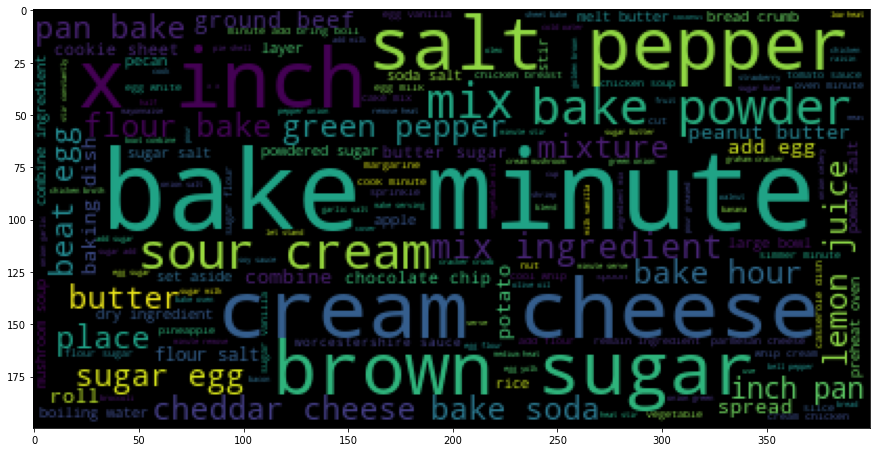

In [17]:
plt.figure(figsize=(15,15))

st=""
for i in k:
  for j in i:
    st+=j+" "
mycloud = wc.WordCloud().generate(st)
plt.imshow(mycloud)

In [18]:
sts=st.split()
distinct=set(sts)
print("number of words: {}\nnumber of unique words: {}".format(len(sts),len(distinct)))

number of words: 388395
number of unique words: 4892


In [19]:
dtoken=[simple_preprocess(d, deacc= True, min_len=3) for d in docslemma]
phrases  = Phrases(dtoken, min_count = 2,threshold=9)
bigram=Phraser(phrases)
bdocs=[bigram[d] for d in dtoken]
bdc=[]
for i in bdocs:
  st=""
  for j in i:
    st+=j+" "
  bdc.append(st)
coll=[' '.join([d for w in l]) for l in bdocs]

In [20]:
for i in bdc[:10]:
  print(i)

bake nut cookie brown sugar milk vanilla nuts butter bite_size shred rice biscuit heavy quart_saucepan mix brown sugar nuts evaporate_milk butter margarine stir medium_heat mixture bubble boil stir minute heat stir vanilla cereal mix teaspoon drop shape cluster wax_paper let_stand firm minute 
jewell ball chicken beef chicken_breast cream mushroom_soup sour_cream place chip beef baking_dish place chicken beef mix soup cream pour chicken bake uncover hour 
creamy corn frozen corn cream cheese butter garlic powder salt pepper slow_cooker combine ingredient cover cook low hour heat cheese melt stir serve yield_serving 
chicken funny chicken chicken gravy cream mushroom_soup shred cheese boil debone_chicken bite_size piece average_size square casserole_dish pour gravy cream mushroom_soup chicken level stuffing accord_instruction box moist stuffing chicken gravy level sprinkle shred cheese bake approximately minute golden bubbly 
reeses cup candy peanut_butter graham_cracker crumb butter po

In [21]:
for i in bdocs[:10]:
  print(i)

['bake', 'nut', 'cookie', 'brown', 'sugar', 'milk', 'vanilla', 'nuts', 'butter', 'bite_size', 'shred', 'rice', 'biscuit', 'heavy', 'quart_saucepan', 'mix', 'brown', 'sugar', 'nuts', 'evaporate_milk', 'butter', 'margarine', 'stir', 'medium_heat', 'mixture', 'bubble', 'boil', 'stir', 'minute', 'heat', 'stir', 'vanilla', 'cereal', 'mix', 'teaspoon', 'drop', 'shape', 'cluster', 'wax_paper', 'let_stand', 'firm', 'minute']
['jewell', 'ball', 'chicken', 'beef', 'chicken_breast', 'cream', 'mushroom_soup', 'sour_cream', 'place', 'chip', 'beef', 'baking_dish', 'place', 'chicken', 'beef', 'mix', 'soup', 'cream', 'pour', 'chicken', 'bake', 'uncover', 'hour']
['creamy', 'corn', 'frozen', 'corn', 'cream', 'cheese', 'butter', 'garlic', 'powder', 'salt', 'pepper', 'slow_cooker', 'combine', 'ingredient', 'cover', 'cook', 'low', 'hour', 'heat', 'cheese', 'melt', 'stir', 'serve', 'yield_serving']
['chicken', 'funny', 'chicken', 'chicken', 'gravy', 'cream', 'mushroom_soup', 'shred', 'cheese', 'boil', 'deb

In [22]:
col_tokenized=bdocs
dictionary=corpora.Dictionary()
BoW=[dictionary.doc2bow(doc, allow_update=True) for doc in col_tokenized]
print(BoW[:20])
[print([(dictionary[id], count) for id, count in line]) for line in BoW[:20]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 2), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 3), (29, 2), (30, 1), (31, 2), (32, 1)], [(0, 1), (20, 1), (33, 1), (34, 1), (35, 3), (36, 3), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 1), (47, 1)], [(6, 1), (13, 1), (28, 1), (39, 1), (40, 1), (48, 2), (49, 1), (50, 1), (51, 2), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1)], [(0, 1), (2, 1), (3, 1), (19, 1), (27, 2), (36, 5), (39, 2), (42, 2), (44, 1), (48, 2), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 3), (75, 2), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2)], [(6, 1), (19, 1), (21, 1), (49, 1), (56, 1), (58, 1), (77, 1), (81, 1), (82, 1), (83, 2), (84, 1), (85, 1), (86, 1), (87, 1)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

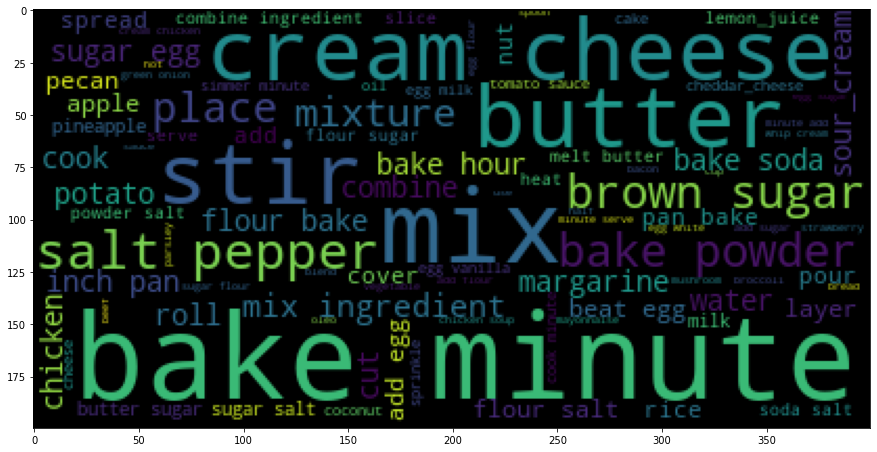

In [23]:
plt.figure(figsize=(15,15))

st=""
for i in bdc:
  st+=i+" "
mycloud = wc.WordCloud().generate(st)
plt.imshow(mycloud)

In [24]:
def printTopics(mdl,p=None):
	for k in range(mdl.k):
		print('Topic #{}'.format(k))
		if p is None:
			for word, prob in mdl.get_topic_words(topic_id=k,top_n=10):
				print(' ', word, prob, sep=' ')
		elif p==1:
			
			for word, prob in mdl.get_topic_words(topic_id=k,top_n=10,timepoint=0):
				print(' ', word, prob, sep=' ')
		else:
			for word, prob in mdl.get_topic_words(sub_topic_id=k,top_n=10):
				print(' ', word, prob, sep=' ')
			
			

def printCoherence(mdl):
	for preset in ('u_mass', 'c_uci', 'c_npmi', 'c_v'):
		coh = tp.coherence.Coherence(mdl, coherence=preset)
		average_coherence = coh.get_score()
		coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdl.k)]
		# print('==== Coherence : {} ===='.format(preset))
		# print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
		# print()
	return average_coherence

def runModel(mdl,docs):
	for i,d in enumerate(docs):
		# print(i,end='')
		#ch = d.split()
		mdl.add_doc(d)
		# print('\r\r\r\r\r\r\r\r\r\r',end='')
	# print()
	mdl.burn_in = 100
	mdl.train(0)
	# print('Num docs:', len(mdl.docs), ', Vocab size:', len(mdl.used_vocabs), ', Num words:', mdl.num_words)
	# print('Removed top words:', mdl.removed_top_words)
	# print('Training...', file=sys.stderr, flush=True)
	for i in range(0, 2000, 10):
		mdl.train(10)
		# print('Iteration: {}\tLog-likelihood: {}'.format(i, mdl.ll_per_word))
    
	mdl.summary()
	# print('Saving...', file=sys.stderr, flush=True)
	mdl.save('test.lda.bin', True)


#Attempt 1

In [50]:
cv=[]
R=range(100,1000,150)
# model=1
# if model==1 or model==0:
for i in R:
	# print('************************** Running LDA ***************************')
	#cp=tp.utils.Corpus(tokenizer=tp.utils.SimpleTokenizer()) #tokenizer=tp.utils.SimpleTokenizer())
	#cp.process(coll)
	mdl = tp.LDAModel(tw=tp.TermWeight.IDF, min_cf=3, rm_top=5, k=i,seed=7773) #,corpus=cp
	runModel(mdl,bdocs)
	#    for n, line in enumerate(open(input_file, encoding='utf-8')):
	# printTopics(mdl)
	cv.append(printCoherence(mdl))

# if model==2 or model==0:
# 	print('************************** Running DMR ***************************')
# 	mdl = tp.DMRModel(tw=tp.TermWeight.IDF, min_cf=3, rm_top=5, k=10,seed=7773) #,corpus=cp
# 	runModel(mdl)
# 	printTopics(mdl)













# 	printCoherence(mdl)

# if model==3 or model==0:
# 	print('************************** Running DTM ***************************')
# 	mdl = tp.DTModel(tw=tp.TermWeight.IDF, min_cf=3, rm_top=5, k=10,seed=7773) #,corpus=cp
# 	runModel(mdl)
# 	printTopics(mdl,1)
# 	#printCoherence(mdl)

# if model==4 or model==0:
# 	print('************************** Running CTM ***************************')
# 	mdl = tp.CTModel(tw=tp.TermWeight.IDF, min_cf=3, rm_top=5, k=10)
# 	runModel(mdl)
# 	printTopics(mdl)
# 	printCoherence(mdl)
	
# if model==5 or model==0:
# 	print('************************** Running HDP ***************************')
# 	mdl = tp.HDPModel(tw=tp.TermWeight.IDF, min_cf=3, rm_top=5, initial_k=10)
# 	runModel(mdl)
# 	printTopics(mdl)
# 	printCoherence(mdl)

# if model==6 or model==0:
# 	print('************************** Running HLDA ***************************')
# 	mdl = tp.HLDAModel(tw=tp.TermWeight.IDF, min_cf=3, rm_top=5)
# 	runModel(mdl)
# 	printTopics(mdl)
# 	printCoherence(mdl)

# if model==7 or model==0:
# 	print('************************** Running MGLDA ***************************')
# 	mdl = tp.MGLDAModel (tw=tp.TermWeight.IDF, min_cf=3, rm_top=5,k_g=10,k_l=10)
# 	runModel(mdl)
# 	printTopics(mdl)
# 	printCoherence(mdl)

# if model==8 or model==0:
# 	print('************************** Running PA ***************************')
# 	mdl = tp.PAModel (tw=tp.TermWeight.IDF, min_cf=3, rm_top=5,k1=10,k2=10)
# 	runModel(mdl)
# 	printTopics(mdl,2)
# 	printCoherence(mdl)

# if model==9 or model==0:
# 	print('************************** Running HPA ***************************')
# 	mdl = tp.HPAModel (tw=tp.TermWeight.IDF, min_cf=3, rm_top=5,k1=10,k2=10)
# 	runModel(mdl)
# 	printTopics(mdl)
# 	printCoherence(mdl)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.


<Basic Info>
| LDAModel (current version: 0.12.3)
| 10000 docs, 296409 words
| Total Vocabs: 6389, Used Vocabs: 3767
| Entropy of words: 6.29047
| Entropy of term-weighted words: 7.08801
| Removed Vocabs: add sugar bake minute mix
|
<Training Info>
| Iterations: 2000, Burn-in steps: 100
| Optimization Interval: 10
| Log-likelihood per word: -5.89437
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 5 (the number of top words to be removed)
| k: 100 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 7773 (random seed)
| trained in version 0.12.3
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distribu

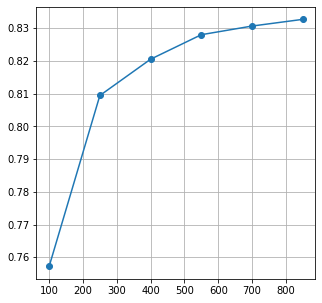

(0.8326990198142387, 850)


In [51]:
plt.figure(figsize=(5,5))
plt.plot(list(R),cv,marker='o')
plt.grid(True)
plt.show()
print(max(zip(cv,list(R))))

#Attempt 2

In [27]:
cv=[]
R=range(200,300,15)
for i in R:
	mdl = tp.LDAModel(tw=tp.TermWeight.IDF, min_cf=3, rm_top=5, k=i,seed=7773)
	runModel(mdl,bdocs)
	cv.append(printCoherence(mdl))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.


<Basic Info>
| LDAModel (current version: 0.12.3)
| 10000 docs, 296409 words
| Total Vocabs: 6389, Used Vocabs: 3767
| Entropy of words: 6.29047
| Entropy of term-weighted words: 7.08801
| Removed Vocabs: add sugar bake minute mix
|
<Training Info>
| Iterations: 2000, Burn-in steps: 100
| Optimization Interval: 10
| Log-likelihood per word: -5.69060
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 5 (the number of top words to be removed)
| k: 200 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 7773 (random seed)
| trained in version 0.12.3
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distribu

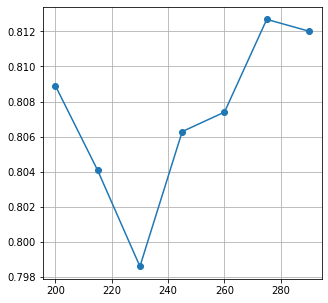

(0.8126910528052937, 275)


In [28]:
plt.figure(figsize=(5,5))
plt.plot(list(R),cv,marker='o')
plt.grid(True)
plt.show()
print(max(zip(cv,list(R))))

#Attempt 3

In [29]:
cv=[]
R=range(180,220,5)
for i in R:
	mdl = tp.LDAModel(tw=tp.TermWeight.IDF, min_cf=3, rm_top=5, k=i,seed=7773)
	runModel(mdl,bdocs)
	cv.append(printCoherence(mdl))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.


<Basic Info>
| LDAModel (current version: 0.12.3)
| 10000 docs, 296409 words
| Total Vocabs: 6389, Used Vocabs: 3767
| Entropy of words: 6.29047
| Entropy of term-weighted words: 7.08801
| Removed Vocabs: add sugar bake minute mix
|
<Training Info>
| Iterations: 2000, Burn-in steps: 100
| Optimization Interval: 10
| Log-likelihood per word: -5.71692
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 5 (the number of top words to be removed)
| k: 180 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 7773 (random seed)
| trained in version 0.12.3
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distribu

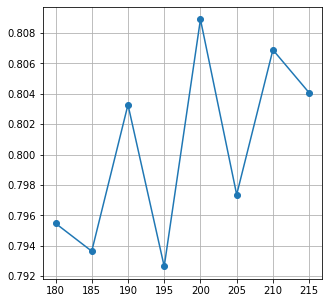

(0.8089038643985986, 200)


In [30]:
plt.figure(figsize=(5,5))
plt.plot(list(R),cv,marker='o')
plt.grid(True)
plt.show()
print(max(zip(cv,list(R))))

#Results

In [33]:
mdl = tp.LDAModel(tw=tp.TermWeight.IDF, min_cf=3, rm_top=5, k=200,seed=7773)
runModel(mdl,bdocs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.


<Basic Info>
| LDAModel (current version: 0.12.3)
| 10000 docs, 296409 words
| Total Vocabs: 6389, Used Vocabs: 3767
| Entropy of words: 6.29047
| Entropy of term-weighted words: 7.08801
| Removed Vocabs: add sugar bake minute mix
|
<Training Info>
| Iterations: 2000, Burn-in steps: 100
| Optimization Interval: 10
| Log-likelihood per word: -5.69060
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 5 (the number of top words to be removed)
| k: 200 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 7773 (random seed)
| trained in version 0.12.3
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distribu

#A Idea

In [53]:
cv=[]
R=range(2,100,5)
for i in R:
	mdl = tp.LDAModel(tw=tp.TermWeight.IDF, min_cf=3, rm_top=5, k=i,seed=7773)
	runModel(mdl,bdocs)
	cv.append(printCoherence(mdl)/i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.


<Basic Info>
| LDAModel (current version: 0.12.3)
| 10000 docs, 296409 words
| Total Vocabs: 6389, Used Vocabs: 3767
| Entropy of words: 6.29047
| Entropy of term-weighted words: 7.08801
| Removed Vocabs: add sugar bake minute mix
|
<Training Info>
| Iterations: 2000, Burn-in steps: 100
| Optimization Interval: 10
| Log-likelihood per word: -6.86153
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 5 (the number of top words to be removed)
| k: 2 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 7773 (random seed)
| trained in version 0.12.3
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributi

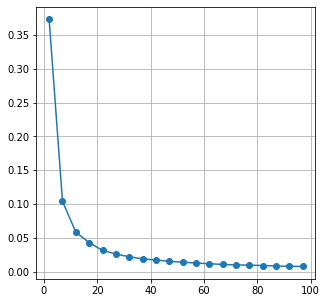

(0.37297867983579636, 2)


In [54]:
plt.figure(figsize=(5,5))
plt.plot(list(R),cv,marker='o')
plt.grid(True)
plt.show()
print(max(zip(cv,list(R))))

In [55]:
cv=[]
R=range(70,90,1)
for i in R:
	mdl = tp.LDAModel(tw=tp.TermWeight.IDF, min_cf=3, rm_top=5, k=i,seed=7773)
	runModel(mdl,bdocs)
	cv.append(printCoherence(mdl))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.


<Basic Info>
| LDAModel (current version: 0.12.3)
| 10000 docs, 296409 words
| Total Vocabs: 6389, Used Vocabs: 3767
| Entropy of words: 6.29047
| Entropy of term-weighted words: 7.08801
| Removed Vocabs: add sugar bake minute mix
|
<Training Info>
| Iterations: 2000, Burn-in steps: 100
| Optimization Interval: 10
| Log-likelihood per word: -6.02451
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 5 (the number of top words to be removed)
| k: 70 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 7773 (random seed)
| trained in version 0.12.3
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distribut

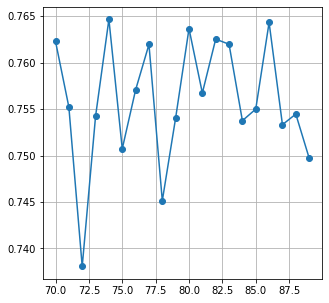

(0.7646509160665242, 74)


In [56]:
plt.figure(figsize=(5,5))
plt.plot(list(R),cv,marker='o')
plt.grid(True)
plt.show()
print(max(zip(cv,list(R))))

#Model

In [30]:
from gensim.models import LdaModel
myModel = LdaModel(corpus = BoW,num_topics= 74, random_state= 27644437, id2word = dictionary, alpha = 'auto',per_word_topics = True,passes = 100)
for t in myModel.show_topics():
  print(t)

(2, '0.139*"basil" + 0.072*"low_fat" + 0.052*"paste" + 0.041*"prepared" + 0.034*"ahead" + 0.030*"calorie" + 0.029*"repeat_layer" + 0.022*"separately" + 0.020*"cooked_rice" + 0.020*"min"')
(20, '0.122*"soy_sauce" + 0.116*"shrimp" + 0.100*"fry" + 0.048*"stir" + 0.048*"add" + 0.038*"garlic" + 0.032*"pear" + 0.030*"heat" + 0.022*"grate" + 0.021*"minute"')
(29, '0.140*"orange" + 0.085*"cranberry" + 0.052*"add" + 0.041*"jello" + 0.040*"salad" + 0.037*"fruit" + 0.032*"pineapple" + 0.032*"sugar" + 0.030*"mix" + 0.026*"mandarin_orange"')
(51, '0.372*"broccoli" + 0.082*"turkey" + 0.061*"mayonnaise" + 0.042*"cook" + 0.040*"great" + 0.028*"chive" + 0.027*"onion" + 0.026*"hash_brown" + 0.023*"cooked" + 0.016*"combine"')
(59, '0.163*"tortilla" + 0.061*"yield" + 0.061*"green_chilie" + 0.045*"avocado" + 0.045*"wedge" + 0.044*"serve_immediately" + 0.037*"diced" + 0.034*"chilie" + 0.027*"quart_saucepan" + 0.024*"medium_size"')
(69, '0.159*"pan" + 0.154*"cake" + 0.113*"mix" + 0.074*"bake" + 0.069*"minute

In [32]:
# docs topics
for i,d in enumerate(BoW): # collection and bagofwords must be synchronized
  print(bdocs[i],':',myModel.get_document_topics(d,minimum_probability=0.3)) #threshold

Streaming output truncated to the last 5000 lines.
['pickled', 'pepper', 'long', 'red', 'pickle', 'salt', 'garlic', 'horseradish', 'vinegar', 'water', 'sugar', 'wash', 'drain', 'pepper', 'cut', 'small', 'slit', 'pepper', 'dissolve', 'salt', 'gallon', 'water', 'pour', 'pepper', 'let_stand', 'hour', 'cool', 'place', 'drain_rinse', 'drain', 'thoroughly', 'combine', 'remain_ingredient', 'simmer', 'minute', 'remove', 'garlic', 'pack', 'pepper', 'jar', 'leave', 'inch_headspace', 'bring', 'liquid', 'boil', 'fill', 'jar', 'inch', 'boiling', 'liquid', 'remove', 'air_bubble', 'adjust_lid', 'process', 'minute', 'boiling_water', 'bath', 'yield_pint'] : [(41, 0.31408465)]
['banana', 'nut', 'salad', 'jello', 'salt', 'boiling_water', 'cold_water', 'lemon_juice', 'banana', 'celery', 'pecan', 'dissolve_gelatin', 'salt', 'boiling_water', 'add', 'cold_water', 'lemon_juice', 'chill', 'thickened', 'fold', 'banana', 'slice', 'celery', 'nuts', 'pour', 'cup', 'mold_chill', 'firm_unmold', 'serve', 'crisp', 'le

In [33]:
tops=[]
for k in range(2):
    t=[]
    for wt in myModel.show_topic(k):
      t.append(wt[0])
    tops.append(t)
for t in tops:
  topic_coher=CoherenceModel(topics=[t], texts= bdocs, dictionary=dictionary, coherence='c_v')
  print('topic:',t)
  print('C_v:%.3f'%(topic_coher.get_coherence()))
print("All:")
topic_coher=CoherenceModel(topics=tops, texts= bdocs, dictionary=dictionary, coherence='c_v')
print('C_v:%.3f'%(topic_coher.get_coherence()))
# top topics
print('Topics with the highest coherence score the coherence for each topic.')
myModel.top_topics(corpus=BoW,dictionary=dictionary,coherence='c_v',texts=bdocs,topn=5)

topic: ['cut', 'slice', 'piece', 'inch', 'place', 'thin', 'strip', 'sprinkle', 'pat', 'spread']
C_v:0.283
topic: ['chocolate', 'chocolate_chip', 'nuts', 'nut', 'melt', 'vanilla', 'semi_sweet', 'date', 'brownie', 'stir']
C_v:0.430
All:
C_v:0.545
Topics with the highest coherence score the coherence for each topic.


[([(0.17042463, 'nutmeg'),
   (0.16434722, 'pumpkin'),
   (0.11930265, 'ginger'),
   (0.096924566, 'spice'),
   (0.088713296, 'clove')],
  0.8902158008181725),
 ([(0.09694907, 'bake'),
   (0.09237595, 'flour'),
   (0.090431206, 'soda'),
   (0.08236529, 'shortening'),
   (0.076600224, 'sugar')],
  0.8353846920971092),
 ([(0.11258125, 'sauce'),
   (0.10778155, 'noodle'),
   (0.09658167, 'parmesan_cheese'),
   (0.048389662, 'mozzarella_cheese'),
   (0.041066736, 'pizza')],
  0.8312376502199783),
 ([(0.12582953, 'tomato'),
   (0.09661841, 'pepper'),
   (0.08047273, 'garlic'),
   (0.07919119, 'salt'),
   (0.056163758, 'onion')],
  0.8062238662346536),
 ([(0.23644991, 'juice'),
   (0.058053944, 'orange_juice'),
   (0.055119216, 'serve'),
   (0.03899566, 'pineapple'),
   (0.03781017, 'ginger_ale')],
  0.8006903527818288),
 ([(0.23818964, 'pie'),
   (0.08914498, 'crust'),
   (0.08625617, 'pie_shell'),
   (0.06338719, 'shell'),
   (0.061878018, 'pour')],
  0.7969499764981306),
 ([(0.07817403, '